  Written by: Omid G. Sani

  Last update: Sep, 2024

   # DPAD Tutorial

   ## Overview
   DPAD, which stands for **dissociative and prioritized analysis of dynamics**, is a method for nonlinear dynamical modeling of time-series neural-behavioral data that can simultaneously model, dissociate, and prioritize behaviorally relevant neural dynamics and can test hypotheses about the origin of nonlinearity. Beyond neural-behavioral data, DPAD can also be applied to any other two time-series data to simultaneously model, dissociate, and prioritize their shared dynamics. In this notebook, we will demonstrate some of the use-cases of DPAD in simulated data where the ground truth is known. For more details on the methods and for results in multiple real neural datasets, please see the DPAD paper:

   Omid G. Sani, Bijan Pesaran, Maryam M. Shanechi. *Dissociative and prioritized modeling of behaviorally relevant neural dynamics using recurrent neural networks*. ***Nature Neuroscience*** (2024). https://doi.org/10.1038/s41593-024-01731-2

   Original preprint: https://doi.org/10.1101/2021.09.03.458628

   ## Model
   Given signals $y_k$ (e.g. neural signals) and $z_k$ (e.g. behavior), DPAD learns a dynamic model for $y_k$ while prioritizing the dynamics that are relevant to $z_k$. The DPAD model can be formulated as (Eq. 1 in the [DPAD paper](https://doi.org/10.1038/s41593-024-01731-2)):

   $$ x_{k+1} = A'(x_k) + K(y_k) $$

   $$ y_k = C_y(x_k) + e_k $$

   $$ z_k = C_z(x_k) + \epsilon_k $$

  Multi-input multi-output functions $A'$ (recursion), $K$ (neural input), $C_y$ (neural readout), and $C_z$ (behavior readout) define the model. DPAD with flexible nonlinearity can automatically fit all these nonlinearities to best describe the training data. Further, DPAD allows the user to flexibly set any of these four parameters to be linear or nonlinear. As such, it also enables testing hypotheses about where the origin of nonlinearities is in the dynamical transformation of neural activity to behavior (use-case 4 in the [DPAD paper](https://doi.org/10.1038/s41593-024-01731-2)).

   # Using DPAD
   ## Modeling data
   To use DPAD, you first need to import the DPADModel class, for example by running:
   ```python
   from DPAD import DPADModel
   ```

   You can then use it to model data as:
   ```python
   idSys = DPADModel()
   methodCode = 'DPAD_CzNonLin' # Only Cz will be nonlinear
   args = DPADModel.prepare_args(methodCode)
   idSys.fit(Y, Z, nx=6, n1=2, **args)
   ```

   With the following arguments:
   - `Y` and `Z`: Neural (e.g. LFP signal powers or spike counts) and behavioral data (e.g. joint angles, hand position, etc), respectively. Dimensions are: data x time.

   - `nx`: the total dimension of the latent state in the model.

   - `n1`: the number of latent state dimensions that are going to be dedicated to behaviorally relevant neural dynamics.

   - args: other arguments that specify the type of nonlinearity in each parameter within the model.

   A helper function called `DPADModel.prepare_args` can be used to prepare the additional arguments `args` that are passed to `idSys.fit`. This function simply takes `methodCode` string as input and returns the relevant arguments to pass to `idSys.fit`. For example, in the above code `methodCode` is `'DPAD_CzNonLin'`. In this case, only the behavior readout parameter $C_z$ of the learned model will be nonlinear and all other parameters will be linear. You can inspect the output of `DPADModel.prepare_args` to see how the architecture of each linear/nonlinear model parameter can be specified as an argument to `idSys.fit`.

  After running the above, the learned model will be stored in the `DPADModel` object called `idSys`.

   ## Using the model for dimension reduction, state estimation, neural self-prediction and behavior decoding
   For a learned DPAD model `idSys` you can use the `predict` method to extract the latent state and predict behavior and neural activity given any new neural data as:
   ```python
   zPred, yPred, xPred = idSys.predict(yTest)
   ```
   With the argument:
   - `yTest`: Neural activity `y` in the test data. Dimensions are: time x data dimension.

   And with outputs (all dimensions are time x data dimension):
   - `zPred`: Prediction of behavior using past neural activity at each data point.

   - `yPred`: Prediction of neural activity using past neural activity at each data point.

   - `xPred`: The latent state extracted at each data point.

   We will next go through a complete example of using DPAD for multiple use-cases in data.

   # A complete example of using DPAD for multiple use-cases
   In this example, we will use DPAD to model some simulated data and demonstrate multiple use-cases in that data.

   ## Loading and preparing the data
   First, we import DPAD and a few other useful tools from DPAD and other libraries.

In [17]:
# Run these to enable python 3.11 for Google Colab
# !sudo apt-get update -y
# !sudo apt-get install python3.11 python3.11-dev python3.11-distutils libpython3.11-dev
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.11 2
# !sudo apt-get install pip

In [18]:
%load_ext autoreload
%autoreload 2
!python --version
# !sudo update-alternatives --config python3

!pip install --upgrade DPAD # Install or update to the latest version of DPAD

# Install dependencies only required for this notebook and other development work
!pip install sympy


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python 3.11.4


ERROR: Invalid requirement: '#'

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import logging
import os
import sys

sys.path.insert(0, os.path.join("..", ".."))
# sys.path.insert(0, os.path.join(os.path.dirname(__file__), "..", ".."))

# Setting up logs
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import coloredlogs

coloredlogs.install(
    level=logging.INFO,
    fmt="%(asctime)s %(name)s [%(filename)s > %(lineno)s] %(levelname)s %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    logger=logger,
)


# Prepare plots
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

matplotlib.rcParams["figure.facecolor"] = "w"
matplotlib.rcParams["axes.facecolor"] = "w"
matplotlib.rcParams.update(
    {"font.size": 16, "axes.titlesize": 14, "axes.labelsize": 14}
)

# Import DPAD tools
from DPAD.DPADModel import DPADModel
from DPAD.tools.evaluation import evalPrediction
from DPAD.tools.file_tools import pickle_load
from DPAD.tools.flexible import fitDPADWithFlexibleNonlinearity
from DPAD.tools.plot import prepAxesStyle
from DPAD.tools.plot_model_params import plot_model_params
from DPAD.tools.tools import get_one_hot

# Just to enable loading of the sample simulated data provided here
from PSID import LSSM
from DPAD.tools import SSM

sys.modules["DPAD.SSM"] = SSM
if LSSM.__module__ != "PSID.LSSM":
    import importlib.util
    spec = importlib.util.spec_from_file_location("PSID", "LSSM.py")
    if spec is not None and spec.loader is not None:
        LSSM_module = importlib.util.module_from_spec(spec)
        sys.modules["DPAD.LSSM"] = LSSM_module


# Set random seeds for exact reproducibility
seed = 42
import random

import numpy as np
import tensorflow as tf

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)



   Let's start by loading data from an example model where only $C_z$ is nonlinear:

In [20]:
# Load data
print(os.getcwd())
data_dir = "../../../data"
fName = "sample_data.p"

sample_data_path = os.path.join(data_dir, fName)

print("Loading example data from {}".format(sample_data_path))
data = pickle_load(sample_data_path)
# This data is from an example model with nonlinearity only in the behavior readout parameter Cz.

maxN = int(2 * 1e5)  # Number of data points to use in this notebook
N = np.min((maxN, data["x"].shape[0]))
x = data["x"][:N, :]
y = data["y"][:N, :]
z = data["z"][:N, :]
trueModel = data["csys"]  # The object that contains the true simulated model

nx = trueModel.state_dim  # Total number of latent states in the simulated model
n1 = len(
    trueModel.zDims
)  # The number of latent states in the simulated model that drive behavior (behaviorally relevant)

allYData, allZData = y, z



c:\codes\libs\DPAD\DPAD\source\DPAD\example
Loading example data from ../../../data\sample_data.p


   Let's separate the data into training and test segments.

In [21]:
# Separate data into training and test data:
trainInds = np.arange(np.round(0.9 * allYData.shape[0]), dtype=int)
testInds = np.arange(1 + trainInds[-1], allYData.shape[0])
yTrain = allYData[trainInds, :]
yTest = allYData[testInds, :]
zTrain = allZData[trainInds, :]
zTest = allZData[testInds, :]

  # Use-cases
  ## Use-case 1: Nonlinear dynamical modeling of neural-behavioral dynamics using DPAD
  In this use-case, DPAD with flexible nonlinearity is used to automatically fit the nonlinearities in data (see **Results** in the [DPAD paper](https://doi.org/10.1038/s41593-024-01731-2)). Here we show in a simulation that this approach can learn a model that reaches behavior decoding and neural self-prediction as good as that of the ideal true model.

  ### Model fitting


In [22]:
# The following  function searches over possible nonlinearities and picks the best one based on the training data
settings = {}
settings[
    "min_cores_to_enable_parallelization"
] = 100  # If fewer than this many cores are available, code will not run with parallelization, set to a large number to disable parallelization
# methodCode = "DPAD_GSUT_iCVF2_LSTM_uAKCzCy2HL128U"  # Each nonlinear parameter will be an MLP with either 1 or 2 hidden layers, each with either 64 or 128 hidden units, and recursion (A') will either be an MLP or an LSTM. This is the default setting used for real data in the DPAD paper.
methodCode = "DPAD_GSUT_iCVF2_RTR2_uAKCzCy1HL64U_ErSV16"  # We will use a smaller search space for this simulation.
# A few other useful things to add to the methodCode:
# 1) RTR2: we try fitting with two random parameter initialization and keep the one that gets better loss.
# 2) ErSV16: changes early stopping to 16 epochs, based on an inner validation set (last 20% of the training data). Without this, by default early stopping is 3 epochs and based on training loss.
# See more below under: Tips for avoiding optimization issues

# selectedMethodCode, iCVRes = fitDPADWithFlexibleNonlinearity(
#     yTrain, Z=zTrain, nx=nx, n1=n1, settings=settings, methodCode=methodCode, saveDir=os.path.join("..", "..", "..", "results")
# )

# Typical runtime for this step:
# - For any individual nonlinearity: a couple of minutes
# - For flexible search over all nonlinearity options:
#   + Without parallelization: sum of run times for all considered nonlinearity options
#   + With full parallelization: max of run time across all considered nonlinearity options

# ATTENTION: we commented out the above flexible search step here just to avoid running it by default, 
# but to get the best results for a given data, you should run the `fitDPADWithFlexibleNonlinearity` step.

# To skip the flexible search, comment out the above call to `fitDPADWithFlexibleNonlinearity`
# and simply set `selectedMethodCode` to the desired nonlinearity settings. For example, you can set:
selectedMethodCode = 'DPAD_RTR2_Cz1HL64U_ErSV16'


idSysF = DPADModel()
epochs = 2500  # Default for this is 2500.
# Fitting will stop upon convergence or after at most the specified number of
# epochs. 2500 as the max number of epochs is usually more than enough.
# Here for speed, we can set to something lower, expecting that the decoding
# will not reach that of the true model unless the number of epochs is large
# enough for convergence
# Prepare settings to make desired parameters in the learned model nonlinear
args = DPADModel.prepare_args(selectedMethodCode)
idSysF.fit(yTrain.T, Z=zTrain.T, nx=nx, n1=n1, epochs=epochs, **args)



2024-10-25 19:20:08 DPAD.tools.flexible [flexible.py > 249] INFO Running innerCV to choose among the following 16 variants:
(1) DPAD_RTR2_ErSV16
(2) DPAD_RTR2_A1HL64U_ErSV16
(3) DPAD_RTR2_K1HL64U_ErSV16
(4) DPAD_RTR2_Cz1HL64U_ErSV16
(5) DPAD_RTR2_Cy1HL64U_ErSV16
(6) DPAD_RTR2_uAK1HL64U_ErSV16
(7) DPAD_RTR2_ACz1HL64U_ErSV16
(8) DPAD_RTR2_ACy1HL64U_ErSV16
(9) DPAD_RTR2_KCz1HL64U_ErSV16
(10) DPAD_RTR2_KCy1HL64U_ErSV16
(11) DPAD_RTR2_CzCy1HL64U_ErSV16
(12) DPAD_RTR2_uAKCz1HL64U_ErSV16
(13) DPAD_RTR2_uAKCy1HL64U_ErSV16
(14) DPAD_RTR2_ACzCy1HL64U_ErSV16
(15) DPAD_RTR2_KCzCy1HL64U_ErSV16
(16) DPAD_RTR2_uAKCzCy1HL64U_ErSV16
2024-10-25 19:20:08 DPAD.tools.flexible [flexible.py > 3632] INFO Loading results from ..\..\..\results\3db7fe65_7329c759_N\DPAD_GSUT_iCVF2_RTR2_uAKCzCy1HL64U_ErSV16\.p (4.1MiB, modified: 2024-09-03 22:29:06)
2024-10-25 19:20:08 DPAD.tools.flexible [flexible.py > 4104] INFO Checking whether result file size could be reduced for future loads
2024-10-25 19:20:08 DPAD.tools.fl

Considering 16 possible combinations of location/type for nonlinearities (this might take a while)...


2024-10-25 19:20:08 DPAD.DPADModel [DPADModel.py > 1525] INFO Stage 1: Learning A11, K1, Cz1 (ZType: cont)
2024-10-25 19:20:08 DPAD.RNNModel [RNNModel.py > 1583] INFO Shifting output by 1 samples to train network for 1-step ahead prediction
2024-10-25 19:20:08 DPAD.RNNModel [RNNModel.py > 1743] INFO Have 36 batches each with 31 128-sample data segments (ny_in=1, ny_out=1, nft=0)
2024-10-25 19:20:08 DPAD.tools.model_base_classes [model_base_classes.py > 226] INFO Starting fit attempt 1 of 2
2024-10-25 19:26:54 DPAD.tools.model_base_classes [model_base_classes.py > 114] INFO Restoring model weights from the end of the best epoch: 650 (stopped at 665 epochs).
2024-10-25 19:26:54 DPAD.tools.model_base_classes [model_base_classes.py > 499] INFO 
Epoch 1/666 - loss=rnn_1step_loss=rnn_1step_mse=0.99700034, rnn_1step_R2_maskV_None=0.0021981811, rnn_1step_CC_maskV_None=0.25630692, val_loss=val_rnn_1step_loss=val_rnn_1step_mse=0.97490841, val_rnn_1step_R2_maskV_None=0.0093793934, val_rnn_1step_C

4500/4500 [==============================] - 4s 841us/step


2024-10-25 19:36:13 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_None=0.997, R2_maskV_None=0.003, CC_maskV_None=0.0549


1125/1125 [==============================] - 1s 813us/step


2024-10-25 19:36:20 DPAD.DPADModel [DPADModel.py > 1781] INFO Stage 2: Learning A12, A22, K2, Cy2 (YType: cont)
2024-10-25 19:36:20 DPAD.RNNModel [RNNModel.py > 1583] INFO Shifting output by 1 samples to train network for 1-step ahead prediction
2024-10-25 19:36:20 DPAD.RNNModel [RNNModel.py > 1743] INFO Have 36 batches each with 31 128-sample data segments (ny_in=2, ny_out=1, nft=0)
2024-10-25 19:36:20 DPAD.tools.model_base_classes [model_base_classes.py > 226] INFO Starting fit attempt 1 of 2
2024-10-25 19:37:27 DPAD.tools.model_base_classes [model_base_classes.py > 114] INFO Restoring model weights from the end of the best epoch: 70 (stopped at 85 epochs).
2024-10-25 19:37:27 DPAD.tools.model_base_classes [model_base_classes.py > 499] INFO 
Epoch 1/86 - loss=rnn_1_1step_loss=rnn_1_1step_mse=0.99343544, rnn_1_1step_R2_maskV_None=0.0066678012, rnn_1_1step_CC_maskV_None=0.089915827, val_loss=val_rnn_1_1step_loss=val_rnn_1_1step_mse=0.97387934, val_rnn_1_1step_R2_maskV_None=0.013035655,

4500/4500 [==============================] - 4s 922us/step


2024-10-25 19:46:23 DPAD.DPADModel [DPADModel.py > 2064] INFO Training Z pred after fitting model2_Cz: 
1-step: MSE_maskV_None=0.671, R2_maskV_None=0.329, CC_maskV_None=0.574



**Note:** The fit function in DPAD prints a log of how the losses converge during training. The printed log is useful to see if the error has converged to a value or if it is still decreasing. If the total number of epochs printed in the log is less than the number of epochs passed as the argument of the fit method, then fitting has converged and the number of epochs has been enough. If the total number of epochs printed in the log is equal to the epochs argument, it means that more epochs would result in an even better fit.


In [23]:
print(f'Selected nonlinearity setting: {selectedMethodCode}')

Selected nonlinearity setting: DPAD_RTR2_KCz1HL64U_ErSV16


We see that as expected the selected nonlinearity includes the true location of nonlinearity (`Cz` in this simulation). This analysis however does not answer whether all nonlinearity can be isolated in that parameter (`Cz`). To confirm isolation, a separate analysis is required that we will address later under use-case 4 where we show isolating nonlinearity only in `Cz` is sufficient and reaches a performance similar to the above result from a flexible search over all nonlinearity combinations.


### Using the learned model to estimate the latent state and predict future behavior and neural activity
The `DPADModel` object (here `idSys`) stores the learned model in itself and after learning is done can be used to extract the latent states and decode behavior in new data. To do this, we use the 'predict' method in the learned model. We will then compare the prediction accuracy for behavior and neural activity with those of the true model.

In [24]:
# Predict behavior and neural activity, from past neural activity, using the learned model
print("Computing predictions for the learned model")
zTestPredF, yTestPredF, xTestPredF = idSysF.predict(yTest)

# Compute CC of decoding and self-prediction
zCCNonLinF = evalPrediction(zTest, zTestPredF, "CC")
yCCNonLinF = evalPrediction(yTest, yTestPredF, "CC")

# Decode behavior and do neural self-prediction using the true model for comparison
print(
    "Computing predictions for the true model (slower due to the analytical symbolic implementation of nonlinearity in the true model)"
)
zTestPredIdeal, yTestPredIdeal, xTestPredIdeal = trueModel.predict(yTest)
zCCIdeal = evalPrediction(zTest, zTestPredIdeal, "CC")
yCCIdeal = evalPrediction(yTest, yTestPredIdeal, "CC")

print(
    f"Behavior decoding CC:\n  Flexible DPAD => {np.mean(zCCNonLinF):.3g}, Ideal using true model => {np.mean(zCCIdeal):.3g}"
)
print(
    f"Neural self-prediction CC:\n  Flexible DPAD => {np.mean(yCCNonLinF):.3g}, Ideal using true model => {np.mean(yCCIdeal):.3g}"
)



Computing predictions for the learned model
625/625 [==============================] - 1s 868us/step
Computing predictions for the true model (slower due to the analytical symbolic implementation of nonlinearity in the true model)


applying Cz: 100%|██████████| 20000/20000 [00:16<00:00, 1224.77it/s]

Behavior decoding CC:
  Flexible DPAD => 0.564, Ideal using true model => 0.565
Neural self-prediction CC:
  Flexible DPAD => 0.176, Ideal using true model => 0.177


  As we see in the above printed accuracies, nonlinear DPAD has reached ideal behavior decoding and neural self-prediction accuracy.

  ### Visualizing the learned nonlinear parameter
  Nonlinear DPAD with flexible nonlinearity reaches ideal behavior and neural self-prediction because it can accurately learn nonlinear parameters (assuming enough epochs are used during learning and optimization does not fall into local optima, more on this later). In this example model, the nonlinearity in the true model is only in the behavior readout parameter $C_z$. To see that this nonlinearity is correctly learned by DPAD, we will next plot the true and learned nonlinear functions for this parameter ($C_z$) in this simulation.

313/313 [==============================] - 0s 847us/step


applying Cz: 100%|██████████| 10000/10000 [00:08<00:00, 1233.96it/s]


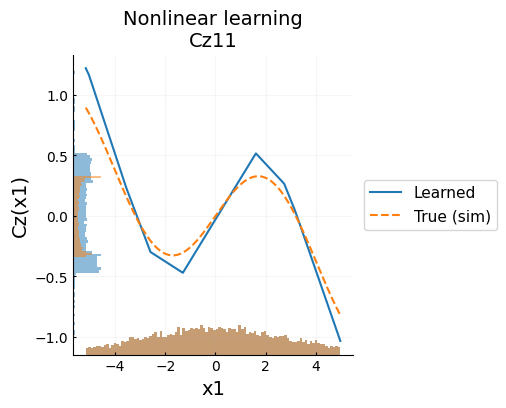

In [25]:
# Plot the true and learned nonlinear parameter
max_samples = np.min([10000, zTestPredF.shape[0]])
plot_model_params(
    idSysF,
    zTestPredF[:max_samples, :],
    yTestPredF[:max_samples, :],
    xTestPredF[:max_samples, :],
    "Nonlinear learning\n",
    trueModel=trueModel,
    ZTrue=zTestPredIdeal[:max_samples, :],
    YTrue=yTestPredIdeal[:max_samples, :],
    XTrue=xTestPredIdeal[:max_samples, :],
    figsize=(8, 6),
    show_hist_x=True,
    show_hist_y=True,
    x_keep_quantiles=[0.05, 0.95],
    params_to_plot=["Cz"],
)



   The distribution of inputs and outputs of $C_z$ in the true data are also shown as histograms on the horizontal and vertical axes, respectively. We see that DPAD very accurately learns the nonlinear behavior readout parameter $C_z$, which was the only nonlinear parameter in the simulated model in this example. Note that with more training samples and more training epochs the learned model will become more and more accurate. Using more hidden layers (e.g., 3 hidden layers) in $C_z$ also results in more accurate fit to the true function in these simulations. More example plots similar to this plot for other locations of nonlinearity are shown in **ED Fig. 2** in the [DPAD paper](https://doi.org/10.1038/s41593-024-01731-2).

  ### Comparing with the linear DPAD model
  Let's compare the behavior and neural predictions from the nonlinear DPAD model with the predictions from a linear DPAD model — note, as we show in the paper (**ED Fig. 1** in the [DPAD paper](https://doi.org/10.1038/s41593-024-01731-2)), linear DPAD does similarly to linear PSID and is thus used as the comparison linear modeling method to show the benefit of nonlinearity in dissociative and prioritized dynamical modeling. We don't expect a linear model to perform well because in this simulation the true model is nonlinear.

In [26]:
# Fit a fully linear model
idSysLin = DPADModel()
methodCodeLin = "DPAD_Linear"  # All parameters will be linear
args = DPADModel.prepare_args(methodCodeLin)
idSysLin.fit(yTrain.T, Z=zTrain.T, nx=nx, n1=n1, epochs=epochs, **args)

# Predict behavior and neural activity, from past neural activity, using the learned model
zTestPredLin, yTestPredLin, xTestPredLin = idSysLin.predict(yTest)

2024-10-25 19:46:53 DPAD.DPADModel [DPADModel.py > 1525] INFO Stage 1: Learning A11, K1, Cz1 (ZType: cont)
2024-10-25 19:46:53 DPAD.RNNModel [RNNModel.py > 1583] INFO Shifting output by 1 samples to train network for 1-step ahead prediction
2024-10-25 19:46:53 DPAD.RNNModel [RNNModel.py > 1743] INFO Have 45 batches each with 31 128-sample data segments (ny_in=1, ny_out=1, nft=0)
2024-10-25 19:47:04 DPAD.tools.model_base_classes [model_base_classes.py > 114] INFO Restoring model weights from the end of the best epoch: 15 (stopped at 17 epochs).
2024-10-25 19:47:04 DPAD.tools.model_base_classes [model_base_classes.py > 499] INFO 
Epoch 1/18 - loss=rnn_1step_loss=rnn_1step_mse=0.9999336, rnn_1step_R2_maskV_None=-0.00014840232, rnn_1step_CC_maskV_None=0.09540651, learning_rate=0.001
Epoch 3/18 - loss=rnn_1step_loss=rnn_1step_mse=0.98778284, rnn_1step_R2_maskV_None=0.011997875, rnn_1step_CC_maskV_None=0.2962338, learning_rate=0.001
Epoch 5/18 - loss=rnn_1step_loss=rnn_1step_mse=0.94948435, 

5625/5625 [==============================] - 5s 814us/step


2024-10-25 19:48:15 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_None=0.997, R2_maskV_None=0.00283, CC_maskV_None=0.0556


5625/5625 [==============================] - 5s 826us/step


2024-10-25 19:48:22 DPAD.DPADModel [DPADModel.py > 1781] INFO Stage 2: Learning A12, A22, K2, Cy2 (YType: cont)
2024-10-25 19:48:22 DPAD.RNNModel [RNNModel.py > 1583] INFO Shifting output by 1 samples to train network for 1-step ahead prediction
2024-10-25 19:48:22 DPAD.RNNModel [RNNModel.py > 1743] INFO Have 45 batches each with 31 128-sample data segments (ny_in=2, ny_out=1, nft=0)
2024-10-25 19:48:53 DPAD.tools.model_base_classes [model_base_classes.py > 114] INFO Restoring model weights from the end of the best epoch: 36 (stopped at 38 epochs).
2024-10-25 19:48:53 DPAD.tools.model_base_classes [model_base_classes.py > 499] INFO 
Epoch 1/39 - loss=rnn_1_1step_loss=rnn_1_1step_mse=0.99516183, rnn_1_1step_R2_maskV_None=0.0041552968, rnn_1_1step_CC_maskV_None=0.070197061, learning_rate=0.001
Epoch 5/39 - loss=rnn_1_1step_loss=rnn_1_1step_mse=0.97574693, rnn_1_1step_R2_maskV_None=0.023573909, rnn_1_1step_CC_maskV_None=0.15439703, learning_rate=0.001
Epoch 9/39 - loss=rnn_1_1step_loss=rn

5625/5625 [==============================] - 5s 874us/step


2024-10-25 19:50:15 DPAD.DPADModel [DPADModel.py > 2064] INFO Training Z pred after fitting model2_Cz: 
1-step: MSE_maskV_None=0.895, R2_maskV_None=0.105, CC_maskV_None=0.324


625/625 [==============================] - 1s 833us/step


In [27]:
# Compute CC of decoding and self-prediction
zCCLin = evalPrediction(zTest, zTestPredLin, "CC")
yCCLin = evalPrediction(yTest, yTestPredLin, "CC")

print(
    "Behavior decoding CC:\n  Linear DPAD model => {:.3g}, Ideal using true model => {:.3g}".format(
        np.mean(zCCLin), np.mean(zCCIdeal)
    )
)
print(
    "Neural self-prediction CC:\n  Linear DPAD model => {:.3g}, Ideal using true model => {:.3g}".format(
        np.mean(yCCLin), np.mean(yCCIdeal)
    )
)



Behavior decoding CC:
  Linear DPAD model => 0.31, Ideal using true model => 0.565
Neural self-prediction CC:
  Linear DPAD model => 0.176, Ideal using true model => 0.177


In [28]:
# Let's plot the predictions and compare with ideal
def plotDecoding(zCCVals, labels, cols, zPerfMeasure="CC", ax=None, figsize=(4, 4)):
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)
    prepAxesStyle(ax)
    # Make bar plot of zCC values
    barlist = ax.bar(np.arange(len(zCCVals)), zCCVals, alpha=0.5)
    ax.set_xticks(np.arange(len(zCCVals)))
    ax.set_xticklabels([L.replace("_", "\n") for L in labels])
    for mi in range(len(barlist)):
        barlist[mi].set_color(cols[mi])
    ax.set_ylabel(f"Behavior decoding {zPerfMeasure}", fontsize=14)
    ax.set_xlabel("", fontsize=14)
    ax.set_title("Behavior decoding", fontsize=14)
    ax.tick_params(axis="both", labelsize=14)
    if ax is None:
        plt.show()


def plotDecodingVsSelfPred(
    zCCVals,
    yCCVals,
    labels,
    cols,
    zPerfMeasure="CC",
    yPerfMeasure="CC",
    ax=None,
    figsize=(8, 4),
):
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 2, 1)
    prepAxesStyle(ax)
    # Make scatter plot of zCC and yCC values
    for mi in range(len(yCCVals)):
        style_args = {"marker": ["x", "+", "o"][mi % 3], "s": [60, 100, 60][mi % 3]}
        if mi % 3 == 2:
            style_args["facecolors"] = "none"
        ax.scatter(
            yCCVals[mi],
            zCCVals[mi],
            color=cols[mi],
            label="\n" + labels[mi],
            **style_args,
        )
    ax.set_xlabel(f"Neural self-prediction {yPerfMeasure}", fontsize=14)
    ax.set_ylabel(f"Behavior decoding {zPerfMeasure}", fontsize=14)
    ax.set_title("Neural-behavior prediction", fontsize=14)
    ax.tick_params(axis="both", labelsize=14)
    xlim = ax.get_xlim()
    if np.diff(xlim) < 0.1:
        ax.set_xlim(
            np.array([np.min(yCCVals), np.max(yCCVals)]) + 0.05 * np.array([-1, 1])
        )
    ylim = ax.get_ylim()
    if np.diff(ylim) < 0.1:
        ax.set_ylim(
            np.array([np.min(zCCVals), np.max(zCCVals)]) + 0.05 * np.array([-1, 1])
        )
    ax.legend(
        bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0, fontsize=14
    )
    if ax is None:
        plt.show()


def plotDecodingAndSelfPred(
    zCCVals,
    yCCVals,
    labels,
    cols,
    zPerfMeasure="CC",
    yPerfMeasure="CC",
    ax=None,
    figsize=(12, 4),
):
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(wspace=0.4)
    ax = fig.add_subplot(1, 3, 1)
    plotDecoding(zCCVals, labels, cols, zPerfMeasure=zPerfMeasure, ax=ax)
    ax = fig.add_subplot(1, 3, 2)
    plotDecodingVsSelfPred(
        zCCVals,
        yCCVals,
        labels,
        cols,
        zPerfMeasure=zPerfMeasure,
        yPerfMeasure=yPerfMeasure,
        ax=ax,
    )
    plt.show()



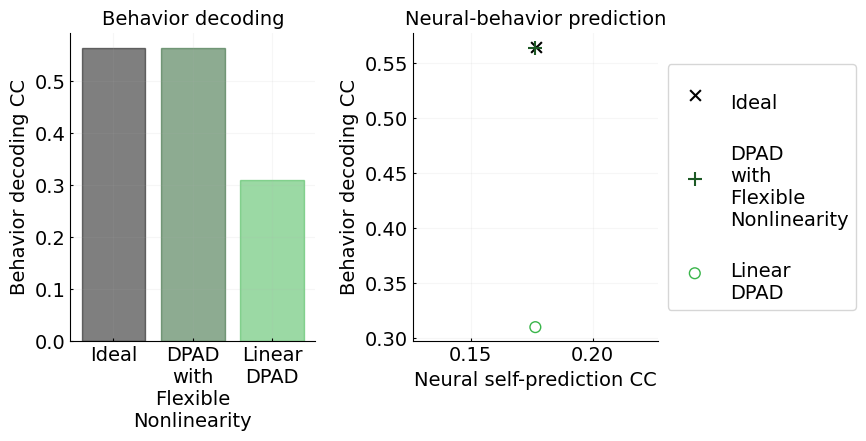

In [29]:
zCCValsL = [np.mean(zCCIdeal), np.mean(zCCNonLinF), np.mean(zCCLin)]
yCCValsL = [np.mean(yCCIdeal), np.mean(yCCNonLinF), np.mean(yCCLin)]
labelsL = ["Ideal", "DPAD\nwith\nFlexible\nNonlinearity", "Linear\nDPAD"]
colsL = ["#010101", "#1d5925", "#39b54a"]
plotDecodingAndSelfPred(zCCValsL, yCCValsL, labelsL, colsL)



  We clearly see that as expected since in this simulation the behavior readout $C_z$ is nonlinear, a linear model can only learn accurate neural self-prediction but would fail to reach an ideal behavior decoding performance. In contrast, nonlinear DPAD can reach ideal performance (similar to the true model) both in terms of behavior decoding and in terms of neural self-prediction.

 ### Tips for avoiding optimization issues
 As noted above, having more and more training data of course helps increase the chances that the model learns an accurate and complete description of the data statistics, which also generalizes to test data. Beyond that, the following are some tips for avoiding issues that are typical for any numerical optimization:
 1. As with any other numerical optimization solved with gradient descent, adjusting the optimizer (e.g. `AdamW`) and its parameters (learning rate, weight decay, etc.) to be suitable for the data can help reduce the chance of getting stuck in local optima. DPAD provides control of the optimizer and its parameter via the parameters of `DPADModel.fit`. Please also see `DPADModel.prepare_args` and the method `parseMethodCodeArgOptimizer` used inside it on how the optimizer settings can be specified simply by changing the `methodCode` string passed to `DPADModel.prepare_args`.
 2. Retrying the model fitting with different random initializations and picking the outcome with the best final training data accuracy is another way to reduce the chance of falling into local optima. DPAD allows this via the `init_attempts` argument to `DPADModel.fit`. This can also be specified by including `RTR{init_attempts}` in the `methodCode` string passed to `DPADModel.prepare_argsgs`. We recommend at least `RTR2`.
 3. Early stopping criteria: by default training stops when the *training* loss does not improve for 3 consecutive epochs (each epoch is running gradient descent once over the whole data). This is not the best option because it may stop training too early. Simply increasing early stopping but still doing it based on *training* loss, it will lead to overfitting. The more reliable setting is to have longer early stopping, but based on a validation data (a part of the training data that we set aside from the optimization in the beginning just for this purpose). To do this, check the parameters of `DPADModel.fit`. Alternatively, add `ErSV{early_stopping_epochs}` to the `methodCode`. For example, adding `ErSV16` will stop training when the validation loss (loss on the last 20% of training data that is initially set aside) does not improve for 16 epochs.

   ## Use-case 2: Extracting behavior-predictive nonlinear features from raw LFP
  As **Fig. 2** in the [DPAD paper](https://doi.org/10.1038/s41593-024-01731-2) shows, DPAD can extend across various neural modalities including spiking, LFP power and raw LFP modalities. In each case, we can use DPAD to quantify the improvement in behavior decoding obtained by going from a linear model to a nonlinear model for the neural-behavioral transformation. Using DPAD, we find that raw LFP gains the most from adding nonlinearity (**Fig. 2**). Also, DPAD extracts nonlinear features from raw LFP that are more behavior-predictive than traditional LFP power features, and sometimes even outperform spiking activity (**Fig. 2**). Our results suggest that the dynamical nonlinear LFP transformations uncovered by DPAD capture the encoding of behavior in LFP more accurately than the traditional nonlinear band power transformations.

   ## Use-case 3: Nonlinear and prioritized dynamic dimensionality reduction
  As **Fig. 5** in the [DPAD paper](https://doi.org/10.1038/s41593-024-01731-2) demonstrates, DPAD enables a dynamic nonlinear dimensionality reduction that extracts behavior-predictive latent states by prioritizing them. Here, the simulated data shown in this notebook is generated from a nonlinear model with $n_x=4$ state dimensions, out of which only $n_1=1$ contribute to the generation of behavior. We will next show the dimension reduction capability of DPAD by fitting models with only 1 total latent state dimension and comparing the results with an RNN of the same latent state dimension that is fitted without prioritization of behaviorally relevant neural dynamics (referred to as NDM, [**Methods**](https://doi.org/10.1038/s41593-024-01731-2)). We also compare the results with the true model that has 4 latent state dimensions. Moreover, for ease of exposition, for both DPAD and NDM we put the nonlinearity in the correct location (consistent with the true simulated model in this example), which is in the behavior readout parameter $C_z$.

In [30]:
# First to make comparisons easier, we create a function that repeats model fitting for a list of methods
def run_methods(
    methodCodesToTry,
    nx,
    n1Vals,
    zPerfMeasure="CC",
    yPerfMeasure="CC",
    zTrainThis=None,
    zTestThis=None,
):
    if zTrainThis is None:
        zTrainThis = zTrain
    if zTestThis is None:
        zTestThis = zTest
    zPerfAll = []
    yPerfAll = []
    labels = []
    idSysAll = []
    for mi, methodCode in enumerate(methodCodesToTry):
        thisN1 = n1Vals[mi % len(n1Vals)]
        print(
            f"Working on {methodCode}, with nx={nx}"
            + (f" and n1={thisN1}" if "DPAD" in methodCode else "")
        )
        args = DPADModel.prepare_args(methodCode)
        idSysThis = DPADModel()
        idSysThis.fit(yTrain.T, Z=zTrainThis.T, nx=nx, n1=thisN1, epochs=epochs, **args)

        # Predict behavior and neural activity, from past neural activity, using the learned model
        zTestPred, yTestPred, xTestPred = idSysThis.predict(yTest)

        # Compute CC of decoding and self-prediction
        zPerf = evalPrediction(zTestThis, zTestPred, zPerfMeasure)
        yPerf = evalPrediction(yTest, yTestPred, yPerfMeasure)

        print(
            f"{methodCode} => Behavior decoding {zPerfMeasure}: {np.mean(zPerf):.3g}, Neural self-prediction {yPerfMeasure}: {np.mean(yPerf):.3g}"
        )

        zPerfAll.append(zPerf)
        yPerfAll.append(yPerf)
        labels.append(methodCode.replace("_", "\n") + f"\nnx={nx}")
        idSysAll.append(idSysThis)
    return zPerfAll, yPerfAll, labels, idSysAll



In [31]:
zCCAll, yCCAll, labels, idSysAll = run_methods(
    [
        "DPAD_CzNonLin",  # Prioritized DPAD model with nonlinearity in Cz
        "NDM_CzNonLin",  # Non-prioritized neural dynamic model (NDM) with nonlinearity in Cz
        # (NDM is a standard RNN model as described in manuscript)
    ],
    nx=n1,  # We use the same low latent state dimension (i.e. n1) for both methods
    n1Vals=[n1, 0],
)  # DPAD can also implement NDM as a special case when n1=0
# (i.e, when only optimization steps 3-4 are used for RNN training)



Working on DPAD_CzNonLin, with nx=1 and n1=1


2024-10-25 19:50:19 DPAD.DPADModel [DPADModel.py > 1525] INFO Stage 1: Learning A11, K1, Cz1 (ZType: cont)
2024-10-25 19:50:19 DPAD.RNNModel [RNNModel.py > 1583] INFO Shifting output by 1 samples to train network for 1-step ahead prediction
2024-10-25 19:50:19 DPAD.RNNModel [RNNModel.py > 1743] INFO Have 45 batches each with 31 128-sample data segments (ny_in=1, ny_out=1, nft=0)
2024-10-25 19:54:19 DPAD.tools.model_base_classes [model_base_classes.py > 114] INFO Restoring model weights from the end of the best epoch: 304 (stopped at 306 epochs).
2024-10-25 19:54:19 DPAD.tools.model_base_classes [model_base_classes.py > 499] INFO 
Epoch 1/307 - loss=rnn_1step_loss=rnn_1step_mse=0.99779677, rnn_1step_R2_maskV_None=0.0019997836, rnn_1step_CC_maskV_None=0.27276608, learning_rate=0.001
Epoch 32/307 - loss=rnn_1step_loss=rnn_1step_mse=0.67671072, rnn_1step_R2_maskV_None=0.32295364, rnn_1step_CC_maskV_None=0.56885511, learning_rate=0.001
Epoch 63/307 - loss=rnn_1step_loss=rnn_1step_mse=0.6763

5625/5625 [==============================] - 5s 877us/step


2024-10-25 19:55:32 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_None=0.997, R2_maskV_None=0.00288, CC_maskV_None=0.0561


625/625 [==============================] - 1s 802us/step
DPAD_CzNonLin => Behavior decoding CC: 0.564, Neural self-prediction CC: 0.0483
Working on NDM_CzNonLin, with nx=1


2024-10-25 19:55:41 DPAD.DPADModel [DPADModel.py > 1781] INFO Stage 2: Learning A12, A22, K2, Cy2 (YType: cont)
2024-10-25 19:55:41 DPAD.RNNModel [RNNModel.py > 1583] INFO Shifting output by 1 samples to train network for 1-step ahead prediction
2024-10-25 19:55:41 DPAD.RNNModel [RNNModel.py > 1743] INFO Have 45 batches each with 31 128-sample data segments (ny_in=1, ny_out=1, nft=0)
2024-10-25 19:55:52 DPAD.tools.model_base_classes [model_base_classes.py > 114] INFO Restoring model weights from the end of the best epoch: 13 (stopped at 15 epochs).
2024-10-25 19:55:52 DPAD.tools.model_base_classes [model_base_classes.py > 499] INFO 
Epoch 1/16 - loss=rnn_1step_loss=0.99896455, rnn_1step_R2_maskV_None=0.00034890836, rnn_1step_CC_maskV_None=0.11471912, rnn_1step_mse=0.99896449, learning_rate=0.001
Epoch 3/16 - loss=rnn_1step_loss=rnn_1step_mse=0.99377221, rnn_1step_R2_maskV_None=0.0055446136, rnn_1step_CC_maskV_None=0.11905371, learning_rate=0.001
Epoch 5/16 - loss=rnn_1step_loss=rnn_1st

5625/5625 [==============================] - 5s 968us/step


2024-10-25 19:58:21 DPAD.DPADModel [DPADModel.py > 2064] INFO Training Z pred after fitting model2_Cz: 
1-step: MSE_maskV_None=0.923, R2_maskV_None=0.0767, CC_maskV_None=0.278


625/625 [==============================] - 1s 911us/step
NDM_CzNonLin => Behavior decoding CC: 0.269, Neural self-prediction CC: 0.116


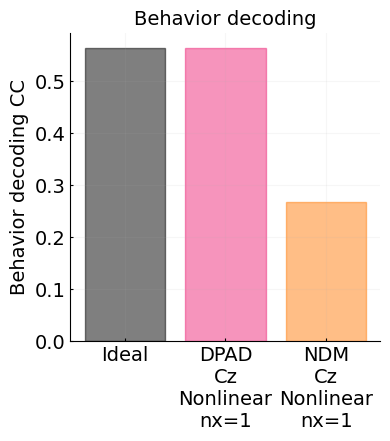

In [32]:
zCCValsP = [np.mean(zCCIdeal)] + [np.mean(v) for v in zCCAll]
labelsP = ["Ideal"] + labels
colsP = ["#010101", "#ee2a7b", "#ff7f0e"]
labelsP2 = [L.replace("NonLin", "\nNonlinear") for L in labelsP]
plotDecoding(zCCValsP, labelsP2, colsP)



  As we can see, DPAD can learn models with low-dimensional latent states that are more behavior-predictive than models learned by methods that do not prioritize the learning of behaviorally relevant neural dynamics. This enables more behavior-predictive dynamic nonlinear dimensionality reduction as another use-case of DPAD. As the manuscript shows, DPAD extracted latent states that were lower-dimensional yet more behavior-predictive than both nonlinear NDM and linear DPAD.

   ## Use-case 4: Testing hypotheses regarding the origin of nonlinearity in the dynamic neural-behavioral transformation
   As **Fig. 6** and **ED Fig. 2** in the [DPAD paper](https://doi.org/10.1038/s41593-024-01731-2) show, DPAD also allows flexible control over nonlinearities: it can make each model parameter linear or nonlinear independent of the other parameters. This flexible control allows us to fit alternative DPAD models with nonlinearity in different model parameters and compare them in terms of cross-validated behavior decoding and neural self-prediction to test hypotheses about where in the neural-behavioral transformation the nonlinearity can be isolated to.

In [33]:
zCCAllH, yCCAllH, labelsH, idSysAllH = run_methods(
    [
        "DPAD_CzNonLin",  # Only Cz will be nonlinear
        "DPAD_CyNonLin",  # Only Cy will be nonlinear
        "DPAD_ANonLin",  # Only A will be nonlinear
        "DPAD_KNonLin",  # Only K will be nonlinear
        "DPAD_Linear",  # Fully linear
    ],
    nx=nx,
    n1Vals=[n1],
)



Working on DPAD_CzNonLin, with nx=4 and n1=1


2024-10-25 19:58:24 DPAD.DPADModel [DPADModel.py > 1525] INFO Stage 1: Learning A11, K1, Cz1 (ZType: cont)
2024-10-25 19:58:24 DPAD.RNNModel [RNNModel.py > 1583] INFO Shifting output by 1 samples to train network for 1-step ahead prediction
2024-10-25 19:58:24 DPAD.RNNModel [RNNModel.py > 1743] INFO Have 45 batches each with 31 128-sample data segments (ny_in=1, ny_out=1, nft=0)
2024-10-25 20:00:13 DPAD.tools.model_base_classes [model_base_classes.py > 114] INFO Restoring model weights from the end of the best epoch: 132 (stopped at 134 epochs).
2024-10-25 20:00:13 DPAD.tools.model_base_classes [model_base_classes.py > 499] INFO 
Epoch 1/135 - loss=rnn_1step_loss=rnn_1step_mse=0.99830782, rnn_1step_R2_maskV_None=0.0014863398, rnn_1step_CC_maskV_None=0.27105826, learning_rate=0.001
Epoch 15/135 - loss=rnn_1step_loss=rnn_1step_mse=0.6825577, rnn_1step_R2_maskV_None=0.3171016, rnn_1step_CC_maskV_None=0.563658, learning_rate=0.001
Epoch 29/135 - loss=rnn_1step_loss=rnn_1step_mse=0.67878848

5625/5625 [==============================] - 5s 815us/step


2024-10-25 20:01:26 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_None=0.997, R2_maskV_None=0.0029, CC_maskV_None=0.0561


5625/5625 [==============================] - 5s 838us/step


2024-10-25 20:01:33 DPAD.DPADModel [DPADModel.py > 1781] INFO Stage 2: Learning A12, A22, K2, Cy2 (YType: cont)
2024-10-25 20:01:33 DPAD.RNNModel [RNNModel.py > 1583] INFO Shifting output by 1 samples to train network for 1-step ahead prediction
2024-10-25 20:01:33 DPAD.RNNModel [RNNModel.py > 1743] INFO Have 45 batches each with 31 128-sample data segments (ny_in=2, ny_out=1, nft=0)
2024-10-25 20:02:33 DPAD.tools.model_base_classes [model_base_classes.py > 114] INFO Restoring model weights from the end of the best epoch: 76 (stopped at 78 epochs).
2024-10-25 20:02:33 DPAD.tools.model_base_classes [model_base_classes.py > 499] INFO 
Epoch 1/79 - loss=rnn_1_1step_loss=rnn_1_1step_mse=0.99632365, rnn_1_1step_R2_maskV_None=0.0029925122, rnn_1_1step_CC_maskV_None=0.058971696, learning_rate=0.001
Epoch 9/79 - loss=rnn_1_1step_loss=rnn_1_1step_mse=0.96845013, rnn_1_1step_R2_maskV_None=0.030858617, rnn_1_1step_CC_maskV_None=0.17635748, learning_rate=0.001
Epoch 17/79 - loss=rnn_1_1step_loss=r

5625/5625 [==============================] - 5s 956us/step


2024-10-25 20:04:56 DPAD.DPADModel [DPADModel.py > 2064] INFO Training Z pred after fitting model2_Cz: 
1-step: MSE_maskV_None=0.671, R2_maskV_None=0.329, CC_maskV_None=0.574


625/625 [==============================] - 1s 915us/step
DPAD_CzNonLin => Behavior decoding CC: 0.564, Neural self-prediction CC: 0.176
Working on DPAD_CyNonLin, with nx=4 and n1=1


2024-10-25 20:05:00 DPAD.DPADModel [DPADModel.py > 1525] INFO Stage 1: Learning A11, K1, Cz1 (ZType: cont)
2024-10-25 20:05:00 DPAD.RNNModel [RNNModel.py > 1583] INFO Shifting output by 1 samples to train network for 1-step ahead prediction
2024-10-25 20:05:00 DPAD.RNNModel [RNNModel.py > 1743] INFO Have 45 batches each with 31 128-sample data segments (ny_in=1, ny_out=1, nft=0)
2024-10-25 20:05:11 DPAD.tools.model_base_classes [model_base_classes.py > 114] INFO Restoring model weights from the end of the best epoch: 15 (stopped at 17 epochs).
2024-10-25 20:05:11 DPAD.tools.model_base_classes [model_base_classes.py > 499] INFO 
Epoch 1/18 - loss=rnn_1step_loss=rnn_1step_mse=1.0002114, rnn_1step_R2_maskV_None=-0.00042704475, rnn_1step_CC_maskV_None=-0.10440478, learning_rate=0.001
Epoch 3/18 - loss=rnn_1step_loss=rnn_1step_mse=0.99368435, rnn_1step_R2_maskV_None=0.0060997168, rnn_1step_CC_maskV_None=0.2852602, learning_rate=0.001
Epoch 5/18 - loss=rnn_1step_loss=rnn_1step_mse=0.9579016,

5625/5625 [==============================] - 5s 963us/step


2024-10-25 20:06:36 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_None=0.997, R2_maskV_None=0.0026, CC_maskV_None=0.0556


5625/5625 [==============================] - 5s 934us/step


2024-10-25 20:06:43 DPAD.DPADModel [DPADModel.py > 1781] INFO Stage 2: Learning A12, A22, K2, Cy2 (YType: cont)
2024-10-25 20:06:43 DPAD.RNNModel [RNNModel.py > 1583] INFO Shifting output by 1 samples to train network for 1-step ahead prediction
2024-10-25 20:06:43 DPAD.RNNModel [RNNModel.py > 1743] INFO Have 45 batches each with 31 128-sample data segments (ny_in=2, ny_out=1, nft=0)
2024-10-25 20:07:51 DPAD.tools.model_base_classes [model_base_classes.py > 114] INFO Restoring model weights from the end of the best epoch: 70 (stopped at 72 epochs).
2024-10-25 20:07:51 DPAD.tools.model_base_classes [model_base_classes.py > 499] INFO 
Epoch 1/73 - loss=rnn_1_1step_loss=rnn_1_1step_mse=0.99558645, rnn_1_1step_R2_maskV_None=0.0037367556, rnn_1_1step_CC_maskV_None=0.0681981, learning_rate=0.001
Epoch 9/73 - loss=rnn_1_1step_loss=rnn_1_1step_mse=0.96920145, rnn_1_1step_R2_maskV_None=0.030107889, rnn_1_1step_CC_maskV_None=0.17498977, learning_rate=0.001
Epoch 17/73 - loss=rnn_1_1step_loss=rnn

5625/5625 [==============================] - 5s 839us/step


2024-10-25 20:09:09 DPAD.DPADModel [DPADModel.py > 2064] INFO Training Z pred after fitting model2_Cz: 
1-step: MSE_maskV_None=0.894, R2_maskV_None=0.106, CC_maskV_None=0.325


625/625 [==============================] - 1s 849us/step
DPAD_CyNonLin => Behavior decoding CC: 0.31, Neural self-prediction CC: 0.176
Working on DPAD_ANonLin, with nx=4 and n1=1


2024-10-25 20:09:14 DPAD.DPADModel [DPADModel.py > 1525] INFO Stage 1: Learning A11, K1, Cz1 (ZType: cont)
2024-10-25 20:09:14 DPAD.RNNModel [RNNModel.py > 1583] INFO Shifting output by 1 samples to train network for 1-step ahead prediction
2024-10-25 20:09:14 DPAD.RNNModel [RNNModel.py > 1743] INFO Have 45 batches each with 31 128-sample data segments (ny_in=1, ny_out=1, nft=0)
2024-10-25 20:10:43 DPAD.tools.model_base_classes [model_base_classes.py > 114] INFO Restoring model weights from the end of the best epoch: 68 (stopped at 70 epochs).
2024-10-25 20:10:43 DPAD.tools.model_base_classes [model_base_classes.py > 499] INFO 
Epoch 1/71 - loss=rnn_1step_loss=rnn_1step_mse=0.99824822, rnn_1step_R2_maskV_None=0.0015366833, rnn_1step_CC_maskV_None=0.27644339, learning_rate=0.001
Epoch 9/71 - loss=rnn_1step_loss=rnn_1step_mse=0.89782917, rnn_1step_R2_maskV_None=0.10184138, rnn_1step_CC_maskV_None=0.32312185, learning_rate=0.001
Epoch 17/71 - loss=rnn_1step_loss=rnn_1step_mse=0.89428061, 

5625/5625 [==============================] - 4s 792us/step


2024-10-25 20:12:08 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_None=0.997, R2_maskV_None=0.00315, CC_maskV_None=0.0589


5625/5625 [==============================] - 5s 846us/step


2024-10-25 20:12:15 DPAD.DPADModel [DPADModel.py > 1781] INFO Stage 2: Learning A12, A22, K2, Cy2 (YType: cont)
2024-10-25 20:12:15 DPAD.RNNModel [RNNModel.py > 1583] INFO Shifting output by 1 samples to train network for 1-step ahead prediction
2024-10-25 20:12:15 DPAD.RNNModel [RNNModel.py > 1743] INFO Have 45 batches each with 31 128-sample data segments (ny_in=2, ny_out=1, nft=0)
2024-10-25 20:12:42 DPAD.tools.model_base_classes [model_base_classes.py > 114] INFO Restoring model weights from the end of the best epoch: 18 (stopped at 20 epochs).
2024-10-25 20:12:42 DPAD.tools.model_base_classes [model_base_classes.py > 499] INFO 
Epoch 1/21 - loss=rnn_1_1step_loss=rnn_1_1step_mse=0.99407578, rnn_1_1step_R2_maskV_None=0.0052423002, rnn_1_1step_CC_maskV_None=0.080575459, learning_rate=0.001
Epoch 4/21 - loss=rnn_1_1step_loss=rnn_1_1step_mse=0.97791874, rnn_1_1step_R2_maskV_None=0.021405313, rnn_1_1step_CC_maskV_None=0.14762598, learning_rate=0.001
Epoch 7/21 - loss=rnn_1_1step_loss=rn

5625/5625 [==============================] - 5s 836us/step


2024-10-25 20:14:44 DPAD.DPADModel [DPADModel.py > 2064] INFO Training Z pred after fitting model2_Cz: 
1-step: MSE_maskV_None=0.893, R2_maskV_None=0.107, CC_maskV_None=0.326


625/625 [==============================] - 1s 796us/step
DPAD_ANonLin => Behavior decoding CC: 0.312, Neural self-prediction CC: 0.175
Working on DPAD_KNonLin, with nx=4 and n1=1


2024-10-25 20:14:49 DPAD.DPADModel [DPADModel.py > 1525] INFO Stage 1: Learning A11, K1, Cz1 (ZType: cont)
2024-10-25 20:14:49 DPAD.RNNModel [RNNModel.py > 1583] INFO Shifting output by 1 samples to train network for 1-step ahead prediction
2024-10-25 20:14:49 DPAD.RNNModel [RNNModel.py > 1743] INFO Have 45 batches each with 31 128-sample data segments (ny_in=1, ny_out=1, nft=0)
2024-10-25 20:18:16 DPAD.tools.model_base_classes [model_base_classes.py > 114] INFO Restoring model weights from the end of the best epoch: 281 (stopped at 283 epochs).
2024-10-25 20:18:16 DPAD.tools.model_base_classes [model_base_classes.py > 499] INFO 
Epoch 1/284 - loss=rnn_1step_loss=rnn_1step_mse=0.998631, rnn_1step_R2_maskV_None=0.0011611329, rnn_1step_CC_maskV_None=0.22527741, learning_rate=0.001
Epoch 30/284 - loss=rnn_1step_loss=rnn_1step_mse=0.86093241, rnn_1step_R2_maskV_None=0.13873993, rnn_1step_CC_maskV_None=0.3734751, learning_rate=0.001
Epoch 59/284 - loss=rnn_1step_loss=rnn_1step_mse=0.8607130

5625/5625 [==============================] - 5s 802us/step


2024-10-25 20:19:04 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_None=0.997, R2_maskV_None=0.00297, CC_maskV_None=0.0568


5625/5625 [==============================] - 5s 853us/step


2024-10-25 20:19:11 DPAD.DPADModel [DPADModel.py > 1781] INFO Stage 2: Learning A12, A22, K2, Cy2 (YType: cont)
2024-10-25 20:19:11 DPAD.RNNModel [RNNModel.py > 1583] INFO Shifting output by 1 samples to train network for 1-step ahead prediction
2024-10-25 20:19:11 DPAD.RNNModel [RNNModel.py > 1743] INFO Have 45 batches each with 31 128-sample data segments (ny_in=2, ny_out=1, nft=0)
2024-10-25 20:19:56 DPAD.tools.model_base_classes [model_base_classes.py > 114] INFO Restoring model weights from the end of the best epoch: 35 (stopped at 37 epochs).
2024-10-25 20:19:56 DPAD.tools.model_base_classes [model_base_classes.py > 499] INFO 
Epoch 1/38 - loss=rnn_1_1step_loss=rnn_1_1step_mse=0.99221951, rnn_1_1step_R2_maskV_None=0.0070929569, rnn_1_1step_CC_maskV_None=0.084521875, learning_rate=0.001
Epoch 5/38 - loss=rnn_1_1step_loss=rnn_1_1step_mse=0.98107505, rnn_1_1step_R2_maskV_None=0.018240752, rnn_1_1step_CC_maskV_None=0.13633689, learning_rate=0.001
Epoch 9/38 - loss=rnn_1_1step_loss=rn

5625/5625 [==============================] - 5s 842us/step


2024-10-25 20:20:57 DPAD.DPADModel [DPADModel.py > 2064] INFO Training Z pred after fitting model2_Cz: 
1-step: MSE_maskV_None=0.859, R2_maskV_None=0.14, CC_maskV_None=0.376


625/625 [==============================] - 1s 803us/step
DPAD_KNonLin => Behavior decoding CC: 0.366, Neural self-prediction CC: 0.174
Working on DPAD_Linear, with nx=4 and n1=1


2024-10-25 20:21:01 DPAD.DPADModel [DPADModel.py > 1525] INFO Stage 1: Learning A11, K1, Cz1 (ZType: cont)
2024-10-25 20:21:01 DPAD.RNNModel [RNNModel.py > 1583] INFO Shifting output by 1 samples to train network for 1-step ahead prediction
2024-10-25 20:21:01 DPAD.RNNModel [RNNModel.py > 1743] INFO Have 45 batches each with 31 128-sample data segments (ny_in=1, ny_out=1, nft=0)
2024-10-25 20:21:11 DPAD.tools.model_base_classes [model_base_classes.py > 114] INFO Restoring model weights from the end of the best epoch: 15 (stopped at 17 epochs).
2024-10-25 20:21:11 DPAD.tools.model_base_classes [model_base_classes.py > 499] INFO 
Epoch 1/18 - loss=rnn_1step_loss=rnn_1step_mse=1.0002804, rnn_1step_R2_maskV_None=-0.00049620069, rnn_1step_CC_maskV_None=-0.12823616, learning_rate=0.001
Epoch 3/18 - loss=rnn_1step_loss=rnn_1step_mse=0.99418348, rnn_1step_R2_maskV_None=0.0056008482, rnn_1step_CC_maskV_None=0.28446439, learning_rate=0.001
Epoch 5/18 - loss=rnn_1step_loss=rnn_1step_mse=0.9591683

5625/5625 [==============================] - 4s 758us/step


2024-10-25 20:22:21 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_None=0.997, R2_maskV_None=0.00283, CC_maskV_None=0.0557


5625/5625 [==============================] - 5s 831us/step


2024-10-25 20:22:28 DPAD.DPADModel [DPADModel.py > 1781] INFO Stage 2: Learning A12, A22, K2, Cy2 (YType: cont)
2024-10-25 20:22:28 DPAD.RNNModel [RNNModel.py > 1583] INFO Shifting output by 1 samples to train network for 1-step ahead prediction
2024-10-25 20:22:28 DPAD.RNNModel [RNNModel.py > 1743] INFO Have 45 batches each with 31 128-sample data segments (ny_in=2, ny_out=1, nft=0)
2024-10-25 20:23:00 DPAD.tools.model_base_classes [model_base_classes.py > 114] INFO Restoring model weights from the end of the best epoch: 39 (stopped at 41 epochs).
2024-10-25 20:23:00 DPAD.tools.model_base_classes [model_base_classes.py > 499] INFO 
Epoch 1/42 - loss=rnn_1_1step_loss=rnn_1_1step_mse=0.99495566, rnn_1_1step_R2_maskV_None=0.0043614283, rnn_1_1step_CC_maskV_None=0.073611788, learning_rate=0.001
Epoch 6/42 - loss=rnn_1_1step_loss=rnn_1_1step_mse=0.97355521, rnn_1_1step_R2_maskV_None=0.025763718, rnn_1_1step_CC_maskV_None=0.16132496, learning_rate=0.001
Epoch 11/42 - loss=rnn_1_1step_loss=r

5625/5625 [==============================] - 5s 860us/step


2024-10-25 20:24:19 DPAD.DPADModel [DPADModel.py > 2064] INFO Training Z pred after fitting model2_Cz: 
1-step: MSE_maskV_None=0.895, R2_maskV_None=0.105, CC_maskV_None=0.324


625/625 [==============================] - 1s 816us/step
DPAD_Linear => Behavior decoding CC: 0.31, Neural self-prediction CC: 0.177


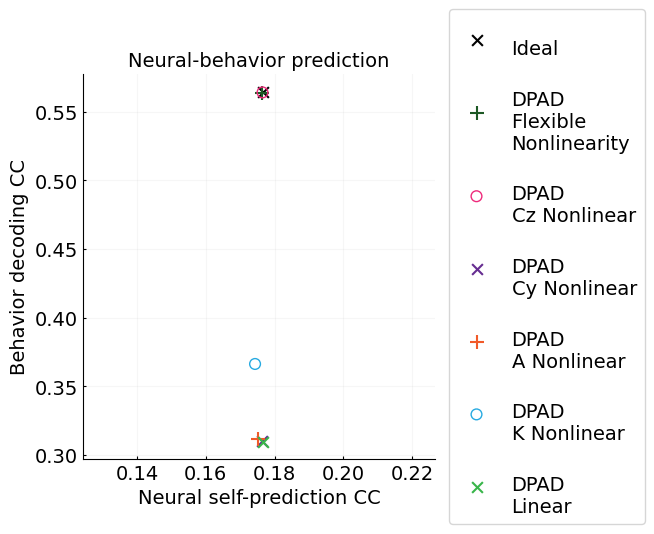

In [34]:
zCCAllHA = [zCCIdeal, zCCNonLinF] + zCCAllH
yCCAllHA = [yCCIdeal, yCCNonLinF] + yCCAllH
labelsHA = ["Ideal", "DPAD\nFlexible\nNonlinearity"] + labelsH
colsHA = []
for label in labelsHA:
    marker = "+"
    if "Ideal" in label:
        col = "#010101"  # Black
    elif "Flexible" in label:
        col = "#1d5925"  # Dark green
    elif "CzNonLin" in label:
        col = "#ee2a7b"  # Magenta
    elif "CyNonLin" in label:
        col = "#662d91"  # Purple
    elif "ANonLin" in label:
        col = "#f15a29"  # Orange
    elif "KNonLin" in label:
        col = "#27aae1"  # Cyan
    elif "Linear" in label:
        col = "#39b54a"  # Light Green
    else:
        col = None
    colsHA.append(col)
labelsHA = [
    L.replace(f"\nnx={nx}", "").replace("NonLin", " Nonlinear") for L in labelsHA
]
plotDecodingVsSelfPred(zCCAllHA, yCCAllHA, labelsHA, colsHA, figsize=(10, 5))



  We see that DPAD correctly identifies the origin of nonlinearity in this simulated example, because the model with the correct nonlinearity (i.e., with nonlinearity in the behavior readout parameter $C_z$) outperforms all other nonlinearities and reaches decoding and self-prediction similar to those of DPAD with flexible nonlinearity. For examples with other locations for nonlinearity see **ED Fig. 2** in the [DPAD paper](https://doi.org/10.1038/s41593-024-01731-2).

  **Note:** If the goal is to model the data as accurately as possible, DPAD with flexible nonlinearity should be used to automatically fit nonlinearities. However, when the goal is to test hypotheses regarding the origin of nonlinearity (use-case 4), DPAD with flexible nonlinearity is not sufficient and one also needs to construct alternative models and compare them as shown in **Results** (**Fig. 6** in the [DPAD paper](https://doi.org/10.1038/s41593-024-01731-2)).

  **Note 2:** Here, for ease of exposition, we only performed training and testing on one train/test split in one simulated data. In the manuscript, we have multiple experimental sessions each giving us performance values for each hypothesis regarding the origin of nonlinearity. Among these hypotheses, we then perform statistical tests to find the nonlinearity that is on the best performance frontier of neural/behavioral prediction, as described in the [DPAD paper](https://doi.org/10.1038/s41593-024-01731-2) (see **Fig. 6a** and the definition of performance frontier in **Results**/**Methods**). See more in **Fig. 6**, **ED Fig. 2**, and **S Fig. 6**.

   ## Use-case 5: Modeling non-Gaussian and intermittently sampled behaviors
  As **Fig. 7** and **ED Figs. 8-9, S Fig. 8** in the [DPAD paper](https://doi.org/10.1038/s41593-024-01731-2) demonstrate, DPAD extends to modeling non-Gaussian and intermittently sampled behaviors, respectively. Here, we will emulate modeling of categorical behavioral data by assigning categories to different ranges of behavior values in the same simulated data. For ease of exposition, here for both DPAD and NDM we put the nonlinearity in the correct location (consistent with the true simulated model in this example), which is in the behavior readout parameter $C_z$.


In [35]:
def getCategory(zCont):
    zCat = np.ones(zCont.shape, dtype=int)
    zCat[zCont < -0.25] = 0  # 1st category
    zCat[np.logical_and(zCont >= -0.25, zCont < 0.25)] = 1  # 2nd category
    zCat[zCont >= 0.25] = 2  # 3rd category
    return zCat


zTrainCat = getCategory(zTrain)
zTestCat = getCategory(zTest)

zAUCAllCat, yCCAllCat, labelsCat, idSysAllCat = run_methods(
    [
        "DPAD_CzNonLin",  # Prioritized DPAD model with nonlinearity in Cz
        "NDM_CzNonLin",  # Non-prioritized neural dynamic model (NDM) with nonlinearity in Cz
        # (NDM is a standard RNN model as described in manuscript)
    ],
    nx=n1,  # We use the same low latent state dimension (i.e. n1) for both methods
    n1Vals=[n1, 0],  # DPAD can also implement NDM as a special case when n1=0
    # (i.e, when only optimization steps 3-4 are used for RNN training)
    zPerfMeasure="AUC",
    zTrainThis=zTrainCat,
    zTestThis=zTestCat,
)

zTestPredIdealCat = get_one_hot(getCategory(zTestPredIdeal), len(np.unique(zTrainCat)))
zAUCIdeal = evalPrediction(zTestCat, zTestPredIdealCat, "AUC")



Working on DPAD_CzNonLin, with nx=1 and n1=1


2024-10-25 20:24:23 DPAD.DPADModel [DPADModel.py > 1525] INFO Stage 1: Learning A11, K1, Cz1 (ZType: cat)
2024-10-25 20:24:23 DPAD.RNNModel [RNNModel.py > 1583] INFO Shifting output by 1 samples to train network for 1-step ahead prediction
2024-10-25 20:24:23 DPAD.RNNModel [RNNModel.py > 1743] INFO Have 45 batches each with 31 128-sample data segments (ny_in=1, ny_out=1, nft=0)
2024-10-25 20:26:22 DPAD.tools.model_base_classes [model_base_classes.py > 114] INFO Restoring model weights from the end of the best epoch: 155 (stopped at 157 epochs).
2024-10-25 20:26:22 DPAD.tools.model_base_classes [model_base_classes.py > 499] INFO 
Epoch 1/158 - loss=rnn_1step_loss=1.0928069, rnn_1step_categorical_crossentropy=1.0928073, learning_rate=0.001
Epoch 17/158 - loss=rnn_1step_loss=0.95470017, rnn_1step_categorical_crossentropy=0.95470029, learning_rate=0.001
Epoch 33/158 - loss=rnn_1step_loss=0.95313323, rnn_1step_categorical_crossentropy=0.95313317, learning_rate=0.001
Epoch 49/158 - loss=rnn_

5625/5625 [==============================] - 4s 787us/step


2024-10-25 20:27:38 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_None=0.997, R2_maskV_None=0.00285, CC_maskV_None=0.0559


625/625 [==============================] - 1s 785us/step
DPAD_CzNonLin => Behavior decoding AUC: 0.688, Neural self-prediction CC: 0.0481
Working on NDM_CzNonLin, with nx=1


2024-10-25 20:27:46 DPAD.DPADModel [DPADModel.py > 1781] INFO Stage 2: Learning A12, A22, K2, Cy2 (YType: cont)
2024-10-25 20:27:46 DPAD.RNNModel [RNNModel.py > 1583] INFO Shifting output by 1 samples to train network for 1-step ahead prediction
2024-10-25 20:27:46 DPAD.RNNModel [RNNModel.py > 1743] INFO Have 45 batches each with 31 128-sample data segments (ny_in=1, ny_out=1, nft=0)
2024-10-25 20:27:55 DPAD.tools.model_base_classes [model_base_classes.py > 114] INFO Restoring model weights from the end of the best epoch: 10 (stopped at 12 epochs).
2024-10-25 20:27:55 DPAD.tools.model_base_classes [model_base_classes.py > 499] INFO 
Epoch 1/13 - loss=rnn_1step_loss=rnn_1step_mse=0.99933577, rnn_1step_R2_maskV_None=-2.2564995e-05, rnn_1step_CC_maskV_None=0.085459374, learning_rate=0.001
Epoch 3/13 - loss=rnn_1step_loss=rnn_1step_mse=0.9944396, rnn_1step_R2_maskV_None=0.0048766984, rnn_1step_CC_maskV_None=0.11960798, learning_rate=0.001
Epoch 5/13 - loss=rnn_1step_loss=rnn_1step_mse=0.98

5625/5625 [==============================] - 5s 937us/step


2024-10-25 20:30:13 DPAD.DPADModel [DPADModel.py > 2064] INFO Training Z pred after fitting model2_Cz: 
1-step: CCE_maskV_None=1.08


625/625 [==============================] - 1s 896us/step
NDM_CzNonLin => Behavior decoding AUC: 0.567, Neural self-prediction CC: 0.116


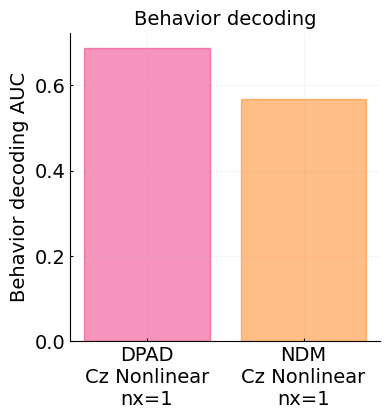

In [36]:
zAUCValsCat = [np.mean(tmp) for tmp in zAUCAllCat]
colsCat = ["#ee2a7b", "#ff7f0e"]
labelsCat2 = [L.replace("NonLin", " Nonlinear") for L in labelsCat]
plotDecoding(zAUCValsCat, labelsCat2, colsCat, zPerfMeasure="AUC")



  As we can see, DPAD extends to modeling categorically distributed behavior data and outperforms nonlinear NDM in that case too. For results in real data see **Fig. 7** in the [DPAD paper](https://doi.org/10.1038/s41593-024-01731-2).